Using a dataset found in UCI website, representing 10 years (1999–2008) of clinical care at 130 US hospitals, I would like to predict if a diabetic patient is at risk of being re-admitted to the hospital after discharge, according to the information contained in this dataset

### Import Librairies

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

# Feature selection / PCA / Clustering
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Model building / hyperparameters tuning / model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from pycaret.classification import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Little viz
import shap

### Get the cleaned data

In [2]:
df=pd.read_csv('3_cleaned_diabetic_data.csv')

# Features selection

I choose to keep the 10th most important columns to build my model

In [3]:
X = df.drop('readmitted', axis=1)
y = df.readmitted

selector = SelectKBest(f_classif, k=15)

X_new = selector.fit_transform(X, y)

column_kept = [column[0]  for column in zip(X.columns,selector.get_support()) if column[1]]

In [4]:
column_kept

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'metformin',
 'insulin',
 'change',
 'diabetesMed',
 'Caucasian',
 'Other_Race',
 'admission_type_id_3']

# Clustering

With the deleted columns, I'm building cluters and see later if these clusters are improving my model

In [5]:
df_cl = df.drop(column_kept, axis=1).drop('readmitted', axis=1)

In [6]:
df_cl.shape

(101732, 21)

## PCA

I'm gonna apply PCA to decrease the number of columns to cluster

In [7]:
pca=PCA(7)
pca.fit(df_cl)
pca.explained_variance_ratio_

array([0.20378661, 0.16000736, 0.10327146, 0.08582321, 0.08004656,
       0.07363201, 0.06459116])

In [8]:
df_pca=pd.DataFrame(pca.transform(df_cl), columns=['PC'+str(i) for i in range(1,8)])
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0.478036,-0.497666,0.150462,1.114762,0.409893,-0.063092,-0.291030
1,-0.541996,-0.405358,0.198464,0.257022,0.715860,-0.056595,-0.420048
2,-0.684436,-0.493984,0.901213,0.216648,0.027798,0.835045,-0.260833
3,-0.457569,0.580226,0.320787,0.246806,0.650328,-0.072910,-0.446904
4,-0.446740,0.611377,0.245356,0.218334,0.546610,0.811336,-0.405326


<AxesSubplot:xlabel='PC1', ylabel='PC4'>

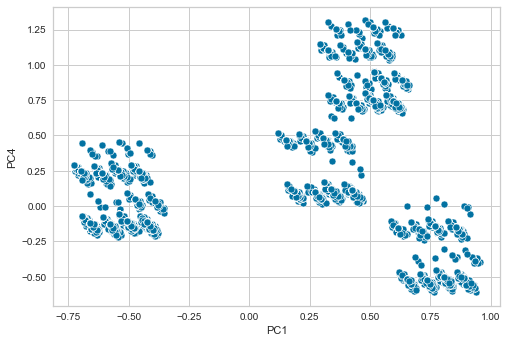

In [9]:
sns.scatterplot(data=df_pca, x='PC1', y='PC4')

## KMEANS

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning


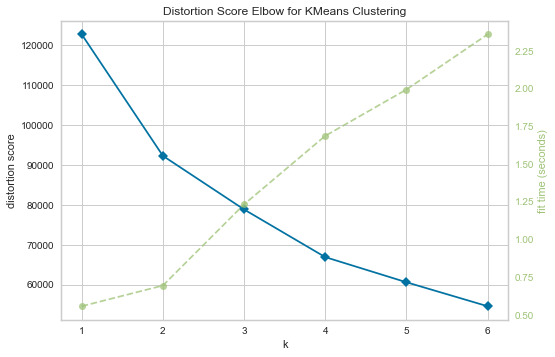

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,7))
visualizer.fit(df_pca)      
visualizer.show()

In [11]:
kmeans=KMeans(3)
kmeans.fit(df_pca)
df['cluster']=kmeans.predict(df_pca)

<AxesSubplot:>

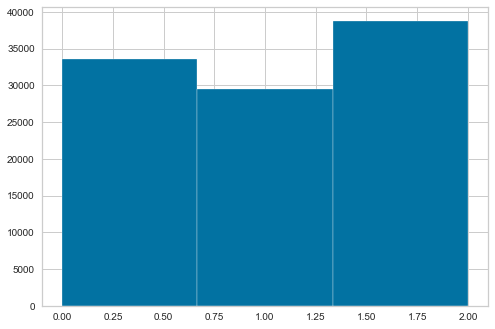

In [12]:
df.cluster.hist(bins=3)

In [13]:
# Adding these clusters into ma dataframe
df['Cluster1']=0
df['Cluster2']=0
df['Cluster3']=0
df.loc[df.cluster==0, 'Cluster1'] = 1
df.loc[df.cluster==1, 'Cluster2'] = 1
df.loc[df.cluster==2, 'Cluster3'] = 1
df.drop('cluster', axis=1, inplace=True)

## Final dataset (for modeling)

In [14]:
col_drop = df_cl.columns.tolist()
dfm = df.drop(col_drop, axis=1)
dfm.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
time_in_hospital,1,3,2,2,1,3,4,5,13,12,9,7,7,10,1,12,4,3,5,6
num_lab_procedures,41,59,11,44,51,31,70,73,68,33,47,62,60,55,49,75,45,29,35,42
num_procedures,0,0,5,1,0,6,1,0,2,3,2,0,0,1,5,5,4,0,5,2
num_medications,1,18,13,16,8,16,21,12,28,18,17,11,15,31,2,13,17,11,23,23
number_outpatient,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
number_emergency,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
number_inpatient,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
number_diagnoses,1,9,6,7,5,9,7,8,8,8,9,7,8,8,8,9,8,3,9,8
metformin,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
insulin,0,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1


## CLASSIFICATION MODELLING

Let's build our model, testing different classifiers

In [15]:
X_train, X_test, y_train, y_test = train_test_split(dfm.drop('readmitted', axis=1)
                                                    ,dfm.readmitted
                                                    ,stratify=dfm.readmitted
                                                    ,random_state=11)

### Decision Tree Classifier

In [16]:
pipe=Pipeline(steps=[('model', DecisionTreeClassifier())])
cv=RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=1)

scores=cross_val_score(pipe, X_train.values, y_train.values.astype('float'), scoring='precision', cv=cv, n_jobs=-1)
print('Mean precision is',np.mean(scores))

Mean precision is 0.5061372570244094


### K Neighbors Classifier

In [20]:
pipe=Pipeline(steps=[('model',KNeighborsClassifier())])
pipe.fit(X_train, y_train)
y_pred1=pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred1))
print('Accuracy Score: '+str(accuracy_score(y_test,y_pred1).round(2)))
print('Recall Score: '+str(recall_score(y_test,y_pred1).round(2)))
print('Precision Score: '+str(precision_score(y_test,y_pred1).round(2)))
print('F1 Score: '+str(f1_score(y_test,y_pred1).round(2)))

[[8865 4845]
 [6285 5438]]
Accuracy Score: 0.56
Recall Score: 0.46
Precision Score: 0.53
F1 Score: 0.49


### Random Forest Classifier

In [21]:
pipe=Pipeline(steps=[('model', RandomForestClassifier())])
pipe.fit(X_train, y_train)
y_pred1=pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred1))
print('Accuracy Score: '+str(accuracy_score(y_test,y_pred1).round(2)))
print('Recall Score: '+str(recall_score(y_test,y_pred1).round(2)))
print('Precision Score: '+str(precision_score(y_test,y_pred1).round(2)))
print('F1 Score: '+str(f1_score(y_test,y_pred1).round(2)))

[[9204 4506]
 [5663 6060]]
Accuracy Score: 0.6
Recall Score: 0.52
Precision Score: 0.57
F1 Score: 0.54


### Random Forest Balanced

In [23]:
pipe=Pipeline(steps=[('model', RandomForestClassifier(class_weight='balanced'))])
pipe.fit(X_train, y_train)
y_pred1=pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred1))
print('Accuracy Score: '+str(accuracy_score(y_test,y_pred1).round(2)))
print('Recall Score: '+str(recall_score(y_test,y_pred1).round(2)))
print('Precision Score: '+str(precision_score(y_test,y_pred1).round(2)))
print('F1 Score: '+str(f1_score(y_test,y_pred1).round(2)))

[[9212 4498]
 [5743 5980]]
Accuracy Score: 0.6
Recall Score: 0.51
Precision Score: 0.57
F1 Score: 0.54


### Logistic Regression

In [22]:
pipe=Pipeline(steps=[('model', LogisticRegression(max_iter = 10000, class_weight='balanced'))])
pipe.fit(X_train, y_train)
y_pred1=pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred1))
print('Accuracy Score: '+str(accuracy_score(y_test,y_pred1).round(2)))
print('Recall Score: '+str(recall_score(y_test,y_pred1).round(2)))
print('Precision Score: '+str(precision_score(y_test,y_pred1).round(2)))
print('F1 Score: '+str(f1_score(y_test,y_pred1).round(2)))

[[9529 4181]
 [5568 6155]]
Accuracy Score: 0.62
Recall Score: 0.53
Precision Score: 0.6
F1 Score: 0.56


### XGBoost Classifier

In [25]:
pipe=Pipeline(steps=[('model', XGBClassifier())])
pipe.fit(X_train, y_train)
y_pred1=pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred1))
print('Accuracy Score: '+str(accuracy_score(y_test,y_pred1).round(2)))
print('Recall Score: '+str(recall_score(y_test,y_pred1).round(2)))
print('Precision Score: '+str(precision_score(y_test,y_pred1).round(2)))
print('F1 Score: '+str(f1_score(y_test,y_pred1).round(2)))

[[9990 3720]
 [5994 5729]]
Accuracy Score: 0.62
Recall Score: 0.49
Precision Score: 0.61
F1 Score: 0.54


### AdaBoost Classifier

In [24]:
pipe=Pipeline(steps=[('model', AdaBoostClassifier())])
pipe.fit(X_train, y_train)
y_pred1=pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred1))
print('Accuracy Score: '+str(accuracy_score(y_test,y_pred1).round(2)))
print('Recall Score: '+str(recall_score(y_test,y_pred1).round(2)))
print('Precision Score: '+str(precision_score(y_test,y_pred1).round(2)))
print('F1 Score: '+str(f1_score(y_test,y_pred1).round(2)))

[[10554  3156]
 [ 6438  5285]]
Accuracy Score: 0.62
Recall Score: 0.45
Precision Score: 0.63
F1 Score: 0.52


According to our 4 different tests, the model obtained with AdaBoost Classifier gives us the best precision and accuracy scores

### Pycaret

Let's check what model is the best according to Pycaret !

In [29]:
data=setup(data=dfm, target='readmitted', numeric_features=['time_in_hospital', 'num_procedures', 'number_diagnoses'])

Setup Succesfully Completed!


,Description,Value
0,session_id,7353
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(101732, 19)"
4,Missing Values,False
5,Numeric Features,8
6,Categorical Features,10
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [30]:
best=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6247,0.6657,0.4723,0.6224,0.5370,0.2313,0.2376,24.7179
1,Light Gradient Boosting Machine,0.6245,0.6656,0.4917,0.6161,0.5469,0.2332,0.2375,1.0386
2,CatBoost Classifier,0.6244,0.6652,0.4889,0.6168,0.5455,0.2327,0.2373,91.8891
3,Ada Boost Classifier,0.6240,0.6614,0.4497,0.6288,0.5243,0.2274,0.2362,7.5893
4,Extreme Gradient Boosting,0.6204,0.6579,0.4945,0.6087,0.5457,0.2257,0.2293,7.3879
5,Logistic Regression,0.6188,0.6568,0.3953,0.6400,0.4887,0.2110,0.2266,2.4666
6,Linear Discriminant Analysis,0.6156,0.6537,0.3822,0.6387,0.4782,0.2032,0.2201,0.6828
7,Ridge Classifier,0.6155,0.0000,0.3815,0.6388,0.4777,0.2030,0.2199,0.2981
8,Naive Bayes,0.6038,0.6336,0.3236,0.6388,0.4295,0.1732,0.1968,0.2157
9,Quadratic Discriminant Analysis,0.6006,0.6471,0.2691,0.6651,0.3831,0.1600,0.1960,0.7551


Pycaret shows us the best model is actually obtained using Gradient Boosting Classifier

In [31]:
model=create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6245,0.6659,0.4648,0.6246,0.5330,0.2302,0.2373
1,0.6255,0.6648,0.4730,0.6237,0.5380,0.2330,0.2394
2,0.6218,0.6656,0.4741,0.6167,0.5361,0.2260,0.2316
3,0.6266,0.6634,0.4781,0.6239,0.5413,0.2356,0.2416
4,0.6248,0.6679,0.4701,0.6232,0.5359,0.2312,0.2377
5,0.6244,0.6641,0.4796,0.6194,0.5406,0.2315,0.2369
6,0.6280,0.6720,0.4775,0.6265,0.5419,0.2383,0.2445
7,0.6246,0.6637,0.4622,0.6256,0.5316,0.2301,0.2374
8,0.6253,0.6691,0.4744,0.6228,0.5386,0.2328,0.2389
9,0.6213,0.6604,0.4691,0.6175,0.5331,0.2244,0.2304


Here we see the best parameters obtained by Gradient Boosting Classifier

In [32]:
tuned_gbc=tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5965,0.6263,0.3667,0.6023,0.4559,0.1643,0.1771
1,0.5977,0.6307,0.3680,0.6046,0.4575,0.1669,0.1799
2,0.5957,0.6190,0.3595,0.6030,0.4505,0.1619,0.1755
3,0.5947,0.6275,0.3641,0.5993,0.4530,0.1606,0.1732
4,0.5953,0.6236,0.3495,0.6056,0.4432,0.1598,0.1747
5,0.5933,0.6248,0.3556,0.5991,0.4463,0.1568,0.1701
6,0.5970,0.6311,0.3473,0.6103,0.4427,0.1628,0.1787
7,0.5902,0.6225,0.3443,0.5960,0.4365,0.1493,0.1633
8,0.5956,0.6264,0.3617,0.6019,0.4518,0.1619,0.1751
9,0.5864,0.6141,0.3515,0.5858,0.4394,0.1430,0.1548


Here we see that parameters are better without tunning...

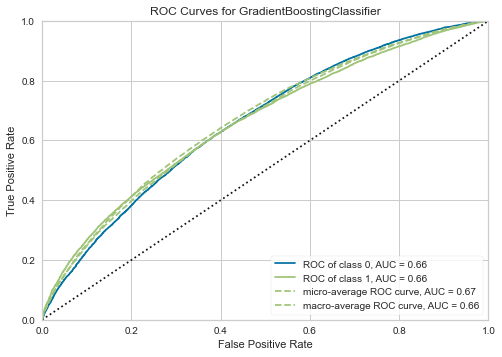

In [34]:
plot_model(best, plot='auc')

# HyperParameter Tunning

Unfortunatly my computer doesn't manage this part (it takes too much time to run the code...)

# Model Evaluation

Let's see what our model is worth after validation

## Baseline model

In [42]:
base = GradientBoostingClassifier()
base.fit(X_train, y_train)
print(confusion_matrix(y_test, base.predict(X_test)))
print('Accuracy Score: '+str(accuracy_score(y_test, base.predict(X_test)).round(2)))
print('Recall Score: '+str(recall_score(y_test,base.predict(X_test)).round(2)))
print('Precision Score: '+str(precision_score(y_test, base.predict(X_test)).round(2)))
print('F1 Score: '+str(f1_score(y_test,base.predict(X_test)).round(2)))
print('AUC Score: '+str(roc_auc_score(y_test, base.predict_proba(X_test)[:,1]).round(2)))

[[12389  4064]
 [ 7508  6559]]
Accuracy Score: 0.62
Recall Score: 0.47
Precision Score: 0.62
F1 Score: 0.53
AUC Score: 0.66


## Pipe model

In [37]:
y_pred = pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('Accuracy Score: '+str(accuracy_score(y_test, y_pred).round(2)))
print('Recall Score: '+str(recall_score(y_test, y_pred).round(2)))
print('Precision Score: '+str(precision_score(y_test, y_pred).round(2)))
print('F1 Score: '+str(f1_score(y_test,y_pred).round(2)))
print('AUC Score: '+str(roc_auc_score(y_test,  pipe.predict_proba(X_test)[:,1]).round(2)))

[[10126  3584]
 [ 6013  5710]]
Accuracy Score: 0.62
Recall Score: 0.49
Precision Score: 0.61
F1 Score: 0.54
AUC Score: 0.66


We obtain better scores with the baseline model of AdaBoost, which are quite similar with Pycaret results

# Features importance 

In [52]:
dct = {X_train.columns[i]:base.feature_importances_[i] for i in range(X_train.shape[1])}

<BarContainer object of 28 artists>

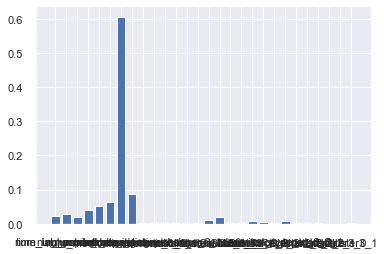

In [71]:
plt.bar(dct.keys(), dct.values())

<BarContainer object of 28 artists>

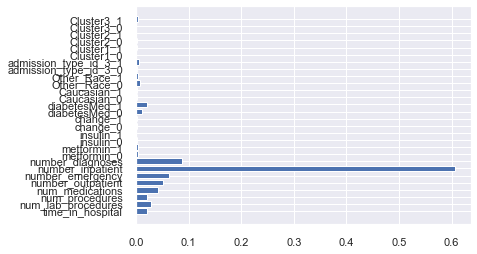

In [79]:
name=list(dct.keys())
value=list(dct.values())
plt.barh(name, value, align = 'center')